In [1]:
import os
import chardet
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from itertools import compress

# Get Fire and Police Station Data

In [4]:
def getPoints(df):
    df = df["WKT"].str.strip("POINT (")
    df = df.str.strip(")")
    df = df.str.split(" ",expand=True)
    df = GeoDataFrame(df,geometry=[Point(xy) for xy in zip(df[0], df[1])],crs=4326)
    return df

In [5]:
police_raw = pd.read_csv("data/map_data/indiana-police-stations.csv")
fire_raw = pd.read_csv("data/map_data/indiana-fire-stations.csv")

police_pts = getPoints(police_raw)
fire_pts = getPoints(fire_raw)
police_pts = police_pts.to_crs(epsg=3857) # WEB MERCATOR (EPSG: 3857), Widely accepted projection, in meters
fire_pts = fire_pts.to_crs(epsg=3857) # WEB MERCATOR (EPSG: 3857), Widely accepted projection, in meters

<h3>Retrieve <code>od_dfs</code> (same as used in raw_data_vis.ipynb)</h3>

In [6]:
od_files=["data_2016.csv","data_2017.csv","data_2018.csv","data_2019.csv"]
years = [name.split(".csv")[0].split("_")[1] for name in od_files]

In [7]:
od_dfs = []
for yr in years:
    df = gpd.read_file("data/saved_odDFs/Dataframe_OD_"+str(yr)+".shp")
    df = df.set_index('county')
    od_dfs.append(df)

# Generate random OD events based on historical data

In [8]:
od_history = od_dfs[0][['geometry']].copy()
maxODs = []
minODs = []
for county in od_history.index:
    allODs = []
    for i in range(len(od_dfs)):
        allODs.append(int(od_dfs[i]['od_count'][county]))
    maxODs.append(max(allODs))
    minODs.append(min(allODs))

od_history['maxODcount'] = maxODs
od_history['minODcount'] = minODs

We now have max/min OD counts for each county based on past data. We can generate a random number of simulated OD calls that's within this range to simulate fluctuation.

Furthermore, since this data is for the entire year, we can add randomness to the days on which these calls are generated. <br>
A maximum duplicate value can be set, to ensure we don't run into a situation where all the calls happen on the same day.

for county in counties:
    N = random.randint(1,maxN) # maxN is max number of days in a year when ODs can happen max(total ODs,days in yr)
    days = random.sample(range(0,365),N) # where N is number of days
    odN = random.randint(minOD,maxOD) # odN is the number of annual cases we will have
    leftover = odN # cases left to simulate
    for day in days:
        if leftover> 0 :
            K = random.randint(0,maxK /* odN) # K is num of cases/day, maxK is max cases a day (% of annual cases)
            leftover = odN - K
            ... something to randomly locate these cases on a map

In [9]:
def generateRandomPts(geometry,n):
    generated = 0
    ptslist = []
    minX,minY,maxX,maxY = geometry.bounds
    while generated < n:
        x = np.random.uniform(minX,maxX,n)
        y = np.random.uniform(minY,maxY,n)
        
        pts = [Point(xi,yi) for xi,yi in zip(x,y)]
        
        contained = geometry.contains(pts)
        generated += contained.sum()
        ptslist+=list(compress(pts,contained))
    return GeoDataFrame(ptslist[:n]).rename(columns={0:'odpts'})

<h4>Wind Information Creation, from winddata2.ipynb</h4>

In [10]:
folder = "data/mesonet_wind_data/"
files = os.listdir(folder)
stations = [filename.strip('.csv') for filename in files]
files = [folder+file for file in files]

stationloc = {'ACRE':(40.47,-86.99),'CCCS':(38.32,-86.35),'DUNLAP':(40.43,-86.27),'DPAC':(40.25,-85.15),
              'FPAC':(38.88,-86.55),'MARTELL':(40.44,-87.03),'NEPAC':(41.1,-85.39),'PPAC':(41.44,-86.92),
              'SEPAC':(39.03,-85.53),'SHFPRS':(38.95,-86.78),'SIPAC':(38.45,-86.69),'SWPAC':(38.73,-87.48),'TPAC':(40.29,-86.9)}

stationgeo = GeoDataFrame(stationloc.keys(),geometry = [Point((lon,lat)) for lat,lon in stationloc.values()],crs=4326)
stationgeo = stationgeo.to_crs(epsg=3857)
stationgeo = stationgeo.rename(columns={0:'station'})
stationgeo = stationgeo.set_index('station')

def convertDate(list_):
    list_.remove("")
    list_ = [int(x) for x in list_]
    
    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    days =   [31,28,31,30,31,30,31,31,30,31, 30, 31]
    return sum(days[0:max(months.index(list_[0]),0)]) + list_[1]

wind_dfs = []
mphtoms = 0.44704 # m/s in 1 mph
for file,station in zip(files,stations):
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(1000))
    encoding = result['encoding']
    df = pd.read_csv(file,encoding = encoding,sep='\t')#.drop(columns=['Date'])
    df.index.names=['Day']
    df = df.rename(columns = {'Stn ID':'station','Date':'day','Avg Wind Speed (mph)':'speed','Wind Direction (°)':'direction','Max Wind Gust (mph)':'gust'})
    df['speed'] *= mphtoms
    df['gust'] *= mphtoms
    df['avgvect'] = list(zip(round(df['speed']*np.cos(np.deg2rad(df['direction'])),3),round(df['speed']*np.sin(np.deg2rad(df['direction'])),3)))
    df['gustvect'] = list(zip(round(df['gust']*np.cos(np.deg2rad(df['direction'])),3),round(df['gust']*np.sin(np.deg2rad(df['direction'])),3)))
    df['day'] = df['day'].str.replace("/","-").str.replace("2022","").str.split("-").apply(convertDate)
    wind_dfs.append(df)

In [11]:
# these global parameters are for evaluating the bugs, in a small amount of cases
# the list that contains the distances from wind stations is empty
# current guess is the day check maybe not working. Should check length of usefulpts
# to find where the bug is
odzero = 0
loczeros = []

def getWindVectors(loc,day):
    global odzero
    global loczeros
    #print(loc)
    windvecs = pd.DataFrame([])
    usefulPts = []
    for idx,station in enumerate(wind_dfs):
        if sum(station['day']==day) > 0:
            usefulPts.append(stationgeo.iloc[[idx]].geometry)
            #print(stations[idx])
    for case in loc.values:
        case = case[0]
        dists = []
        for pt in usefulPts:
            dists.append(float(np.sqrt((pt.x-case.x)**2+(pt.y-case.y)**2)))
        if len(dists) == 0: 
            odzero += 1
            loczeros.append(loc)
            return windvecs
        idxbest = dists.index(min(dists))
        #print(stations[idxbest])
        row = wind_dfs[idxbest][wind_dfs[idxbest]['day']==day]
        windvecs = pd.concat([windvecs,pd.concat([row['avgvect'],row['gustvect']],axis=1)],axis=0)
    return windvecs.reset_index(drop=True)

In [14]:
od_history

,geometry,maxODcount,minODcount
county,,,
Adams,"POLYGON ((-9470194.541 4987432.387, -9470201.1...",24,11
Allen,"POLYGON ((-9483540.524 5051390.887, -9483435.1...",301,244
Bartholomew,"POLYGON ((-9582569.341 4753145.057, -9582570.4...",167,84
Benton,"POLYGON ((-9743374.798 4960820.438, -9743374.7...",5,0
Blackford,"POLYGON ((-9511786.175 4935839.563, -9511789.4...",28,14
...,...,...,...
Washington,"POLYGON ((-9607734.670 4670871.008, -9607758.6...",57,17
Wayne,"POLYGON ((-9484525.813 4847620.006, -9484525.8...",233,121
Wells,"POLYGON ((-9487024.267 5000104.671, -9486733.9...",27,14


In [12]:
daysYr = 365
printOutput = False
odpts = pd.DataFrame([])

for countyName,countygeo,maxOD,minOD in zip(od_history.index,od_history['geometry'],od_history['maxODcount'],od_history['maxODcount']):
    maxDays = min(maxOD,daysYr) # max number of days with OD is either max possible OD count or num of days in a year
    numDays = random.randint(0,maxDays) # number of days that will have OD cases, minimum 1 day
    days = random.sample(range(0,daysYr),numDays) # the actual days in which ODs will occur, sample size is the number of days we want ODs
    
    odYr = random.randint(minOD,maxOD) # count of OD cases that will occur annually, within historical margins
    odRemaining = odYr # as we go through the year, variable to store leftover cases
    
    # We need to set a limit for max OD in a day, to prevent annual OD numbers from happening in a single day
    # However, a single percentage will limit smaller counties to 1 case/day, whereas large counties will have too many/day
    # Thus, we have a piecewise scale. Let N = number of cases a year, then
    # N >= 100, max 1% of annual cases a day (roughly 1-20 cases/day on IN data)
    # N >= 10, max 5% of annual cases a day (roughly 1-5 cases/day on IN data)
    # N >= 0, max 30% of annual cases a day (roughly 1-3 cases/day on IN data)
    maxODday = 0.01 if odYr>=100 else (0.05 if odYr >=10 else 0.3)
    if printOutput: print(str(countyName)+" has: ")
    for day in days: # go through each day we have OD
        if odRemaining > 0: # as long as we still have cases to left simulate for the year
            odDay = random.randint(0,np.ceil(maxODday*odYr)) # number of cases on this day
            odRemaining = odYr - odDay
            if odDay == 0:
                continue
            else:
                newpts = generateRandomPts(countygeo,odDay)
                windvecs = getWindVectors(newpts,day)
                odpts = pd.concat([odpts,pd.concat([newpts,windvecs],axis=1)],axis=0)
                # cases for a day with location, can implement a function here
                # to simulate a drone dispatch
                #break
            if printOutput: print("Day "+str(day)+", "+str(odDay)+" case(s). | ",end='')
            
        else:
            continue
    if printOutput: print("\n")
    #break

In [13]:
odpts

,odpts,avgvect,gustvect
0,POINT (-9463792.73979983 4998871.143744233),"(0.803, -0.056)","(6.288, -0.44)"
0,POINT (-9451485.980655717 4973883.78680959),NaN,NaN
1,POINT (-9448658.369192315 4980435.594335634),NaN,NaN
0,POINT (-9463026.858623104 4979180.085369957),"(-3.808, 1.776)","(-11.344, 5.29)"
0,POINT (-9456577.20508795 4980764.746033164),"(0.462, 0.659)","(3.385, 4.834)"
...,...,...,...
0,POINT (-9526028.465638276 5021524.820725607),"(-1.127, -0.433)","(-6.052, -2.323)"
1,POINT (-9520983.037506714 5020445.249576507),"(-1.127, -0.433)","(-6.052, -2.323)"
0,POINT (-9511029.188644925 5027750.724340884),"(-0.313, 0.253)","(-2.258, 1.829)"
0,POINT (-9501016.709880998 5044636.726676626),"(0.528, -0.607)","(3.226, -3.711)"


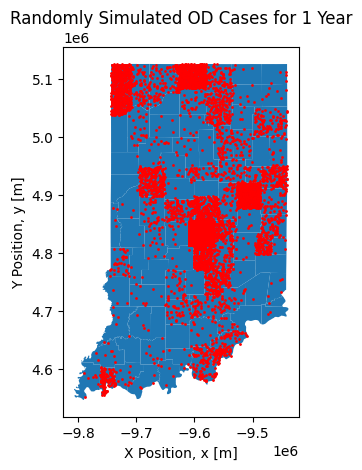

In [173]:
filenum = len(os.listdir('data/random_ODs'))
ax = od_history.plot()
plt.plot([row.x for row in odpts['odpts']],[row.y for row in odpts['odpts']],'o',markersize=1,color='red')
plt.xlabel('X Position, x [m]')
plt.ylabel('Y Position, y [m]')
plt.title('Randomly Simulated OD Cases for 1 Year');
plt.savefig("data/random_ODs/random_ODs_"+str(filenum+1)+".png")

We know (x,y) location of OD case, (x,y) location of fire stations,
avg and gust wind vector, 

useful data: the main use is to use drone's cruise speed to evaluate effectiveness for a year of OD
- so if we find closest station to each OD case, we can get a list of flight distances
- then for a particular cruise speed, we can evaluate T/F for effectiveness
- this also enables evaluation of various drone speeds, i.e. is there a critical speed 
  beyond which a large percent of OD gets covered?
- can be used to target future performance

step 1: for each point, find closest station point and record distance
step 2: use test cruise speed + wind vector to get travel time
- 8k od cases vs. 1.5k stations to compare to

# Exporting Simulated Cases to CSV with Latitude/Longitude Format

In [16]:
odpts_latlon = odpts.copy()
odpts_latlon = GeoDataFrame(odpts_latlon,geometry='odpts',crs=3857)

In [21]:
odpts_latlon = odpts_latlon.to_crs(epsg=4326)
odpts_latlon.to_csv('data/exportData/randomOD.csv')